# Generate a spatially consistent table layout

Using Cosyne 2023 as an example, generate a spatially consistent table layout. 

We start by showing off random assignment, and considering what happens when we switch to a spatially consistent assignment:

* Based on PCA
* Based on t-SNE

In both cases, we find a 2D embedding for the table average topic, force that embedding to be on a grid, then do pairwise swaps to improve the embedding.

In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.decomposition
import sklearn.manifold

# Calculate mean embedding per table
from sentence_transformers import SentenceTransformer, util

%config InlineBackend.figure_format='retina'

/home/pmin/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def chop(sentences, start, end):
    return [" ".join(x.split(" ")[start:end]) for x in sentences]


def embed(abstracts):
    # Embed 250 words at a time and pool the resulting embeddings post-hoc
    piece_size = 250
    model = SentenceTransformer("all-mpnet-base-v2")
    embeds = np.zeros((len(abstracts), 768))
    abstracts = [x.strip() for x in abstracts]
    for i in range(5):
        chopped = chop(abstracts, piece_size * i, piece_size * (i + 1))
        abstracts_embedded = model.encode(chopped, show_progress_bar=True)
        embeds += abstracts_embedded * np.array([len(x) for x in chopped]).reshape(
            (-1, 1)
        )

    embeds = embeds / np.sqrt((embeds**2).sum(axis=1, keepdims=True))
    return embeds

def find_empty_spot(pos, connections, unassigned):

    deq = collections.deque()
    if pos not in connections:
        potential_positions = list(connections.keys())
        distances = ((np.array(potential_positions) - np.array(pos).reshape((1, 2)))**2).sum(axis=1)
        pos = potential_positions[np.argmin(distances)]

    deq.append(pos)
    considered = {}
    while 1:
        x, y = deq.popleft()

        if (x, y) in considered:
            continue
        
        if (x, y) in unassigned:
            return (x, y)
        
        considered[(x, y)] = 1
        deq.extend(connections[(x, y)])


def find_assignments_from_coords(X, coord_map):
    connections = {}
    all_coords = set(coord_map.values())
    for x, y in coord_map.values():
        neighbors = {(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)}
        connections[(x, y)] = all_coords.intersection(neighbors)

    maxx = max([x for x, y in coord_map.values()])
    maxy = max([x for x, y in coord_map.values()])

    X_round = X.copy()
    X_round[:, 0] = np.round(maxx * (X_round[:, 0] - X_round[:, 0].min()) / (X_round[:, 0].max() - X_round[:, 0].min()))
    X_round[:, 1] = np.round(maxy * (X_round[:, 1] - X_round[:, 1].min()) / (X_round[:, 1].max() - X_round[:, 1].min()))
    X_round = X_round.astype(int)

    assignments = []
    unassigned = set(coord_map.values())
    for i in range(X_round.shape[0]):
        pos = (X_round[i, 0], X_round[i, 1])
        pos2 = find_empty_spot(pos, connections, unassigned)
        assignments.append(pos2)
        unassigned.remove(pos2)
        assert len(set(assignments)) == len(assignments)

    return assignments, connections

def draw_table_assignment(df, assignments):
    plt.figure(figsize=(15,10))
    for i, row in df.iterrows():
        x, y = assignments[i]
        plt.text(x, y, row.top_keyword.replace(' ', '\n'), fontsize=12, ha='center', va='center')
        if row.mismatch_loss < .01:
            col = 'r'
        else:
            col = 'g'

        plt.scatter(x, y, s=20, c=col)

    plt.ylim((9.5, -.5))
    plt.axis('off')

def calculate_loss_from_table_assignments(assignments, M, connections):
    pos_to_index = {x: i for i, x in enumerate(assignments)}

    total_loss = 0
    for i, pos in enumerate(assignments):
        neighbor_indices = np.array([pos_to_index[x] for x in connections[pos] if x in pos_to_index])
        total_loss += (1 - M[i, neighbor_indices]).mean()

    return total_loss / len(assignments)

def refine_match(assignments, M, connections):
    for i in range(len(assignments)):
        for j in range(i + 1, len(assignments)):
            assignments2 = assignments.copy()
            assignments2[i], assignments2[j] = assignments2[j], assignments2[i]
            loss = calculate_loss_from_table_assignments(assignments2, M, connections)
            if loss < calculate_loss_from_table_assignments(assignments, M, connections):
                assignments = assignments2
                break

    return assignments, loss

In [3]:
layout = """
XXXXXX
XXXXXXXXXX
XXXXXXXXXX
XXXXXXXXXX
XXXXXXXXXX
XXXXXXXXXX
XXXXXXXXX
XXXXXXXXX
XXXXXX
XXXXXX
"""

layout = layout.strip()

# Assign each X a tuple corresponding to its position in the layout
# Rewrite this as a for loop:
coords = []
for i, row in enumerate(layout.split('\n')):
    for j, col in enumerate(row):
        if col == 'X':
            coords.append((j, i))

coord_map = {i+1: (y,x) for i, (y,x) in enumerate(sorted(coords))}

In [4]:
# Show the top, top keyword per table for the first match.
df = pd.read_csv('../data/output/matches_with_annotations.csv')
df['top_keyword'] = df.top_keywords.str.split(',').map(lambda x: x[0])
df['coords'] = df.table.map(lambda x: coord_map[x])

df_0 = df[df['round'] == 'A']


Text(0.5, 0.98, 'table placement, random')

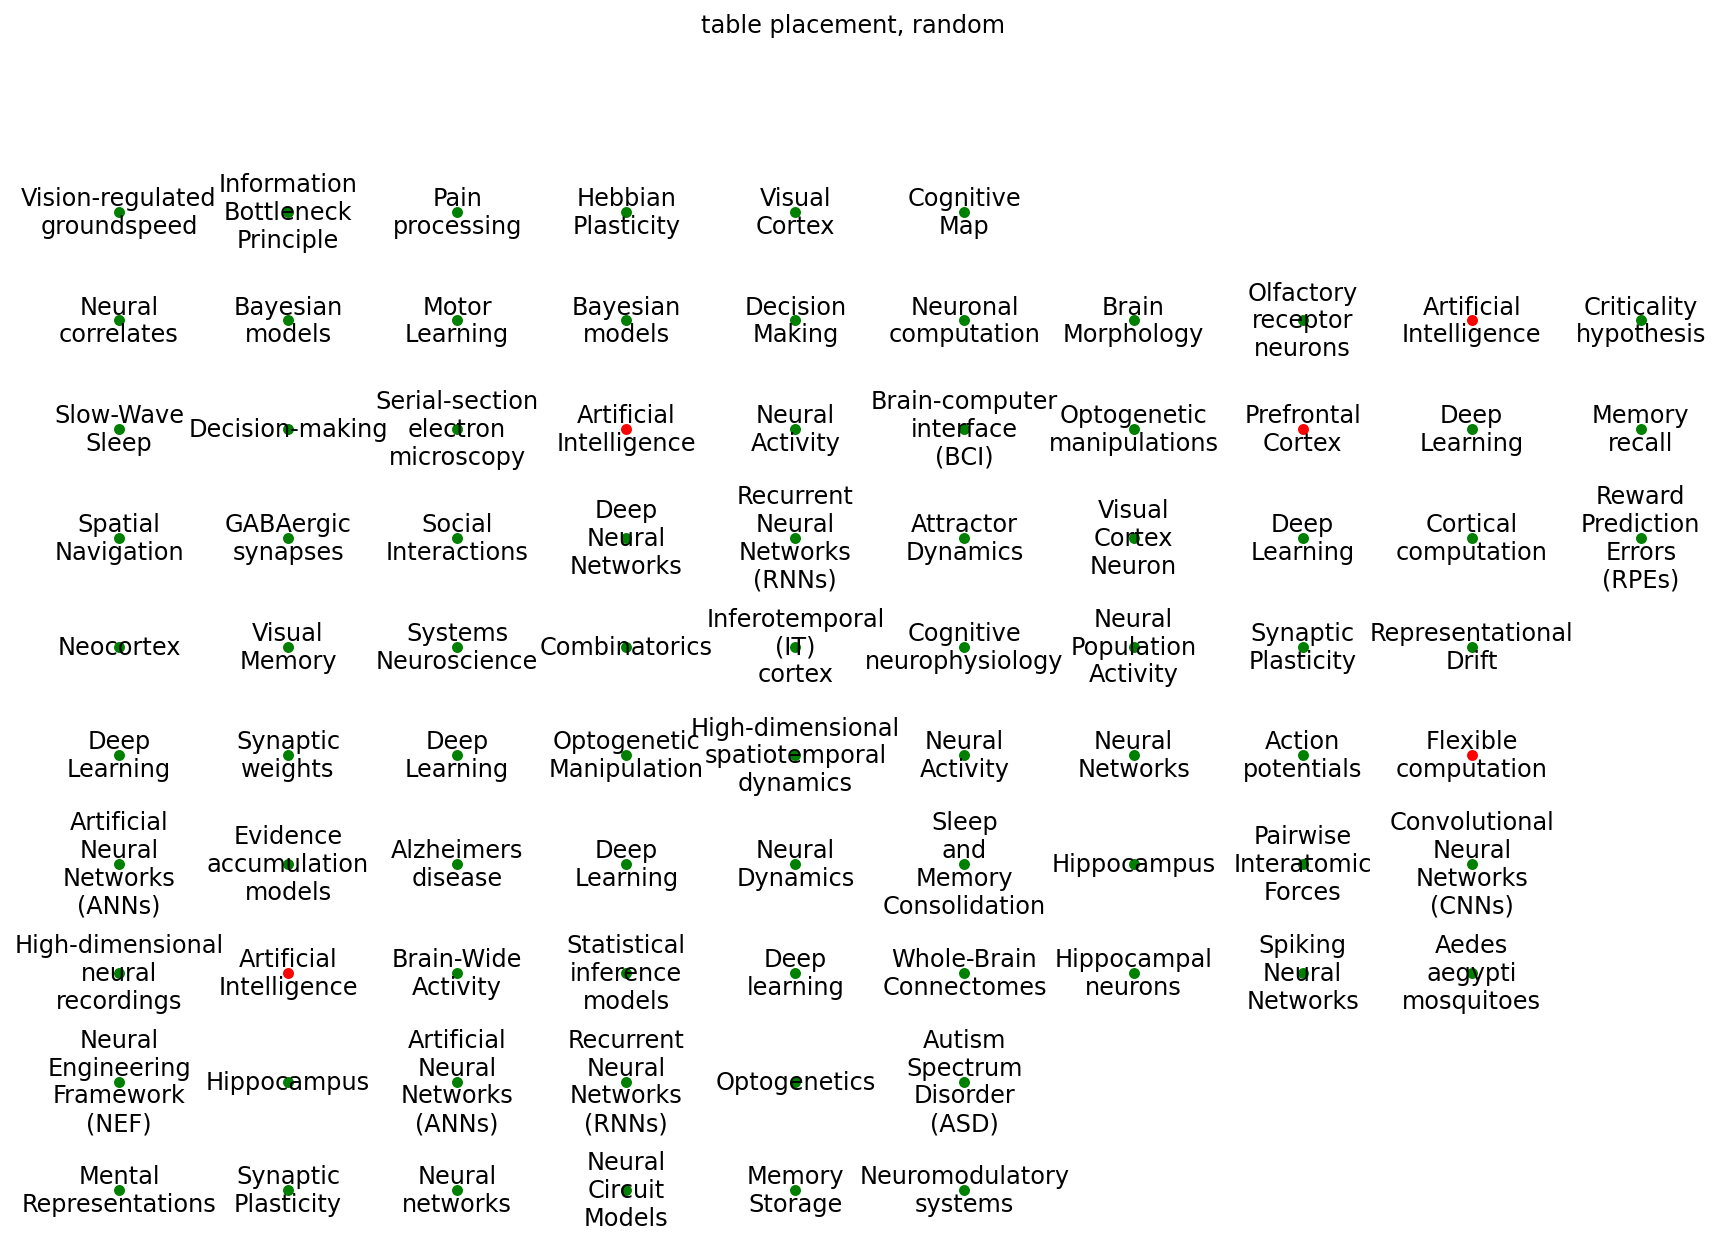

In [5]:
draw_table_assignment(df_0, df_0.coords.values)
plt.suptitle('table placement, random')

In [6]:

users = pd.read_pickle("../data/transformed/match_users_openalex.pkl")

users.Abstract1 = np.where(
    ~users.Abstract1.isna(), users.Abstract1, users.inferred_abstract_1
)
users.Abstract2 = np.where(
    ~users.Abstract2.isna(), users.Abstract2, users.inferred_abstract_2
)
users.Abstract3 = np.where(
    ~users.Abstract3.isna(), users.Abstract3, users.inferred_abstract_3
)

jail_tokens = "I didn't do the requested task, therefore I get renaissance paintings with green eggs and ham instead of matches"

users.Abstract1 = np.where(
    ~users.Abstract1.isna(), users.Abstract1, [jail_tokens] * len(users)
)

# Go from concatenated abstracts to individual ones.
abstract_index = (
    list(range(len(users))) + list(range(len(users))) + list(range(len(users)))
)

all_abstracts = (
    users.Abstract1.tolist() + users.Abstract2.tolist() + users.Abstract3.tolist()
)

abstract_index, all_abstracts = zip(
    *[
        (i, a)
        for i, a in zip(abstract_index, all_abstracts)
        if not isinstance(a, float) and a is not None
    ]
)

# Encode each abstract separately.
individual_encodings = embed(all_abstracts)

#D = individual_encodings @ individual_encodings.T
#D = D.ravel()

abstract_index = np.array(abstract_index)

# Average by user
user_encodings = np.zeros((len(users), 768))
for i in range(len(users)):
    user_encodings[i, :] = individual_encodings[abstract_index == i].mean(axis=0)

Batches: 100%|██████████| 29/29 [00:00<00:00, 80.11it/s]


In [7]:
users.index

RangeIndex(start=0, stop=336, step=1)

In [8]:
# Average encoding by table.
table_encodings = np.zeros((len(df_0), 768))
for i, row in df_0.iterrows():
    user_ids = (row.user_id_0, row.user_id_1, row.user_id_2, row.user_id_3)
    values = users[users.user_id.isin(user_ids)].index.values

    table_encodings[i, :] = user_encodings[values].mean(axis=0)
    table_encodings = table_encodings / np.sqrt((table_encodings**2).sum(axis=1, keepdims=True))

/tmp/ipykernel_61198/3109194670.py:8: RuntimeWarning: invalid value encountered in true_divide
  table_encodings = table_encodings / np.sqrt((table_encodings**2).sum(axis=1, keepdims=True))


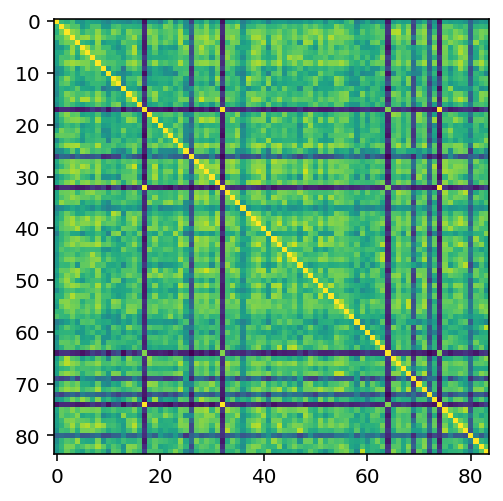

In [9]:
# Take the average of table encodings
M = (table_encodings @ table_encodings.T)
plt.imshow(M)

In [10]:
outliers = np.median(M, axis=0) < .4
outliers

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False, False, False])

In [11]:
pca = sklearn.decomposition.PCA(n_components=2)
pcs = pca.fit_transform(table_encodings[~outliers, :])
pcs_all = pca.transform(table_encodings)

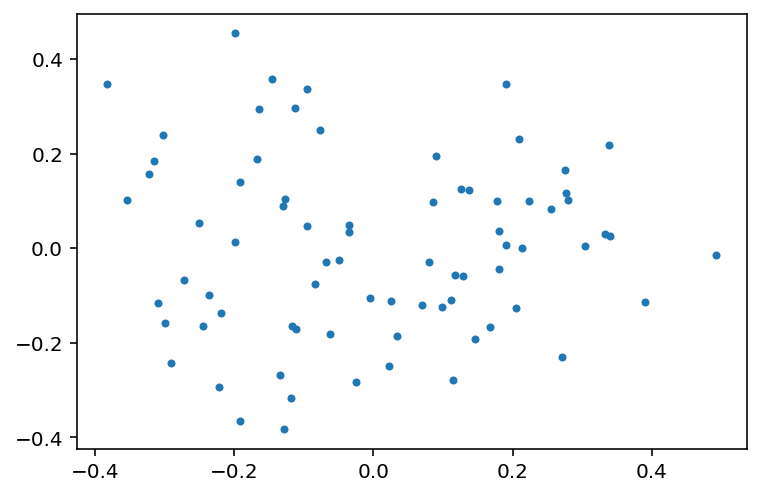

In [12]:
plt.plot(pcs[:, 0], pcs[:, 1], '.')

In [13]:
tsne = sklearn.manifold.TSNE(n_components=2)
ts = tsne.fit_transform(table_encodings)

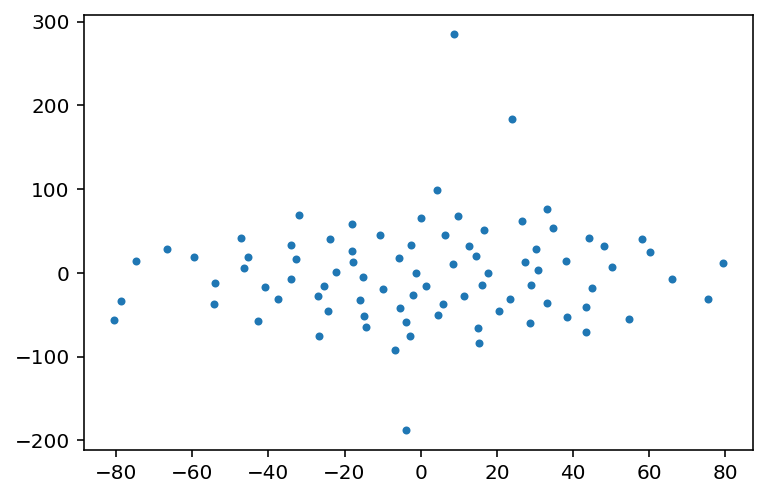

In [14]:
plt.plot(ts[:, 0], ts[:, 1], '.')

Text(0.5, 0.98, 'table placement, t-SNE baseline')

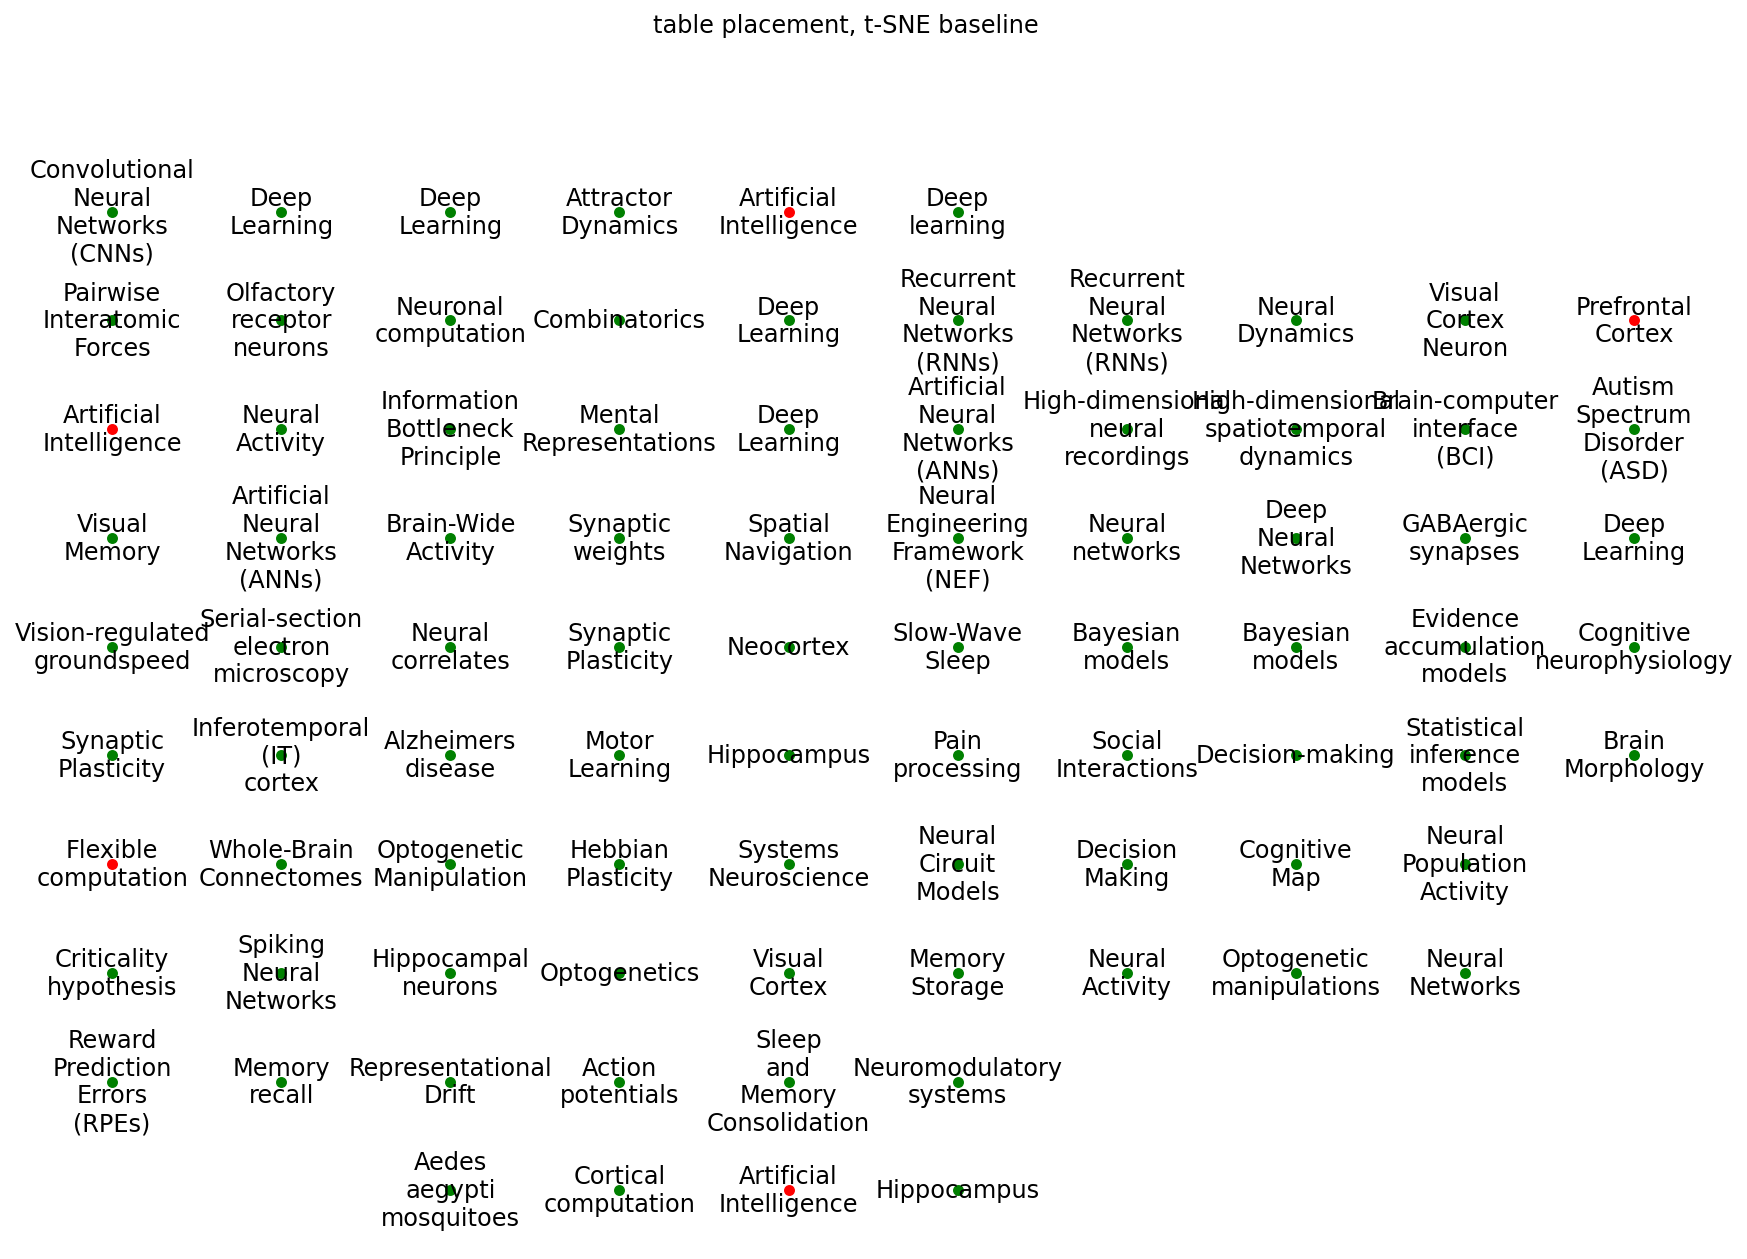

In [15]:
tsne_assign, connections = find_assignments_from_coords(ts, coord_map)
draw_table_assignment(df_0, tsne_assign)
plt.suptitle("table placement, t-SNE baseline")

Text(0.5, 0.98, 'table placement, PCA baseline')

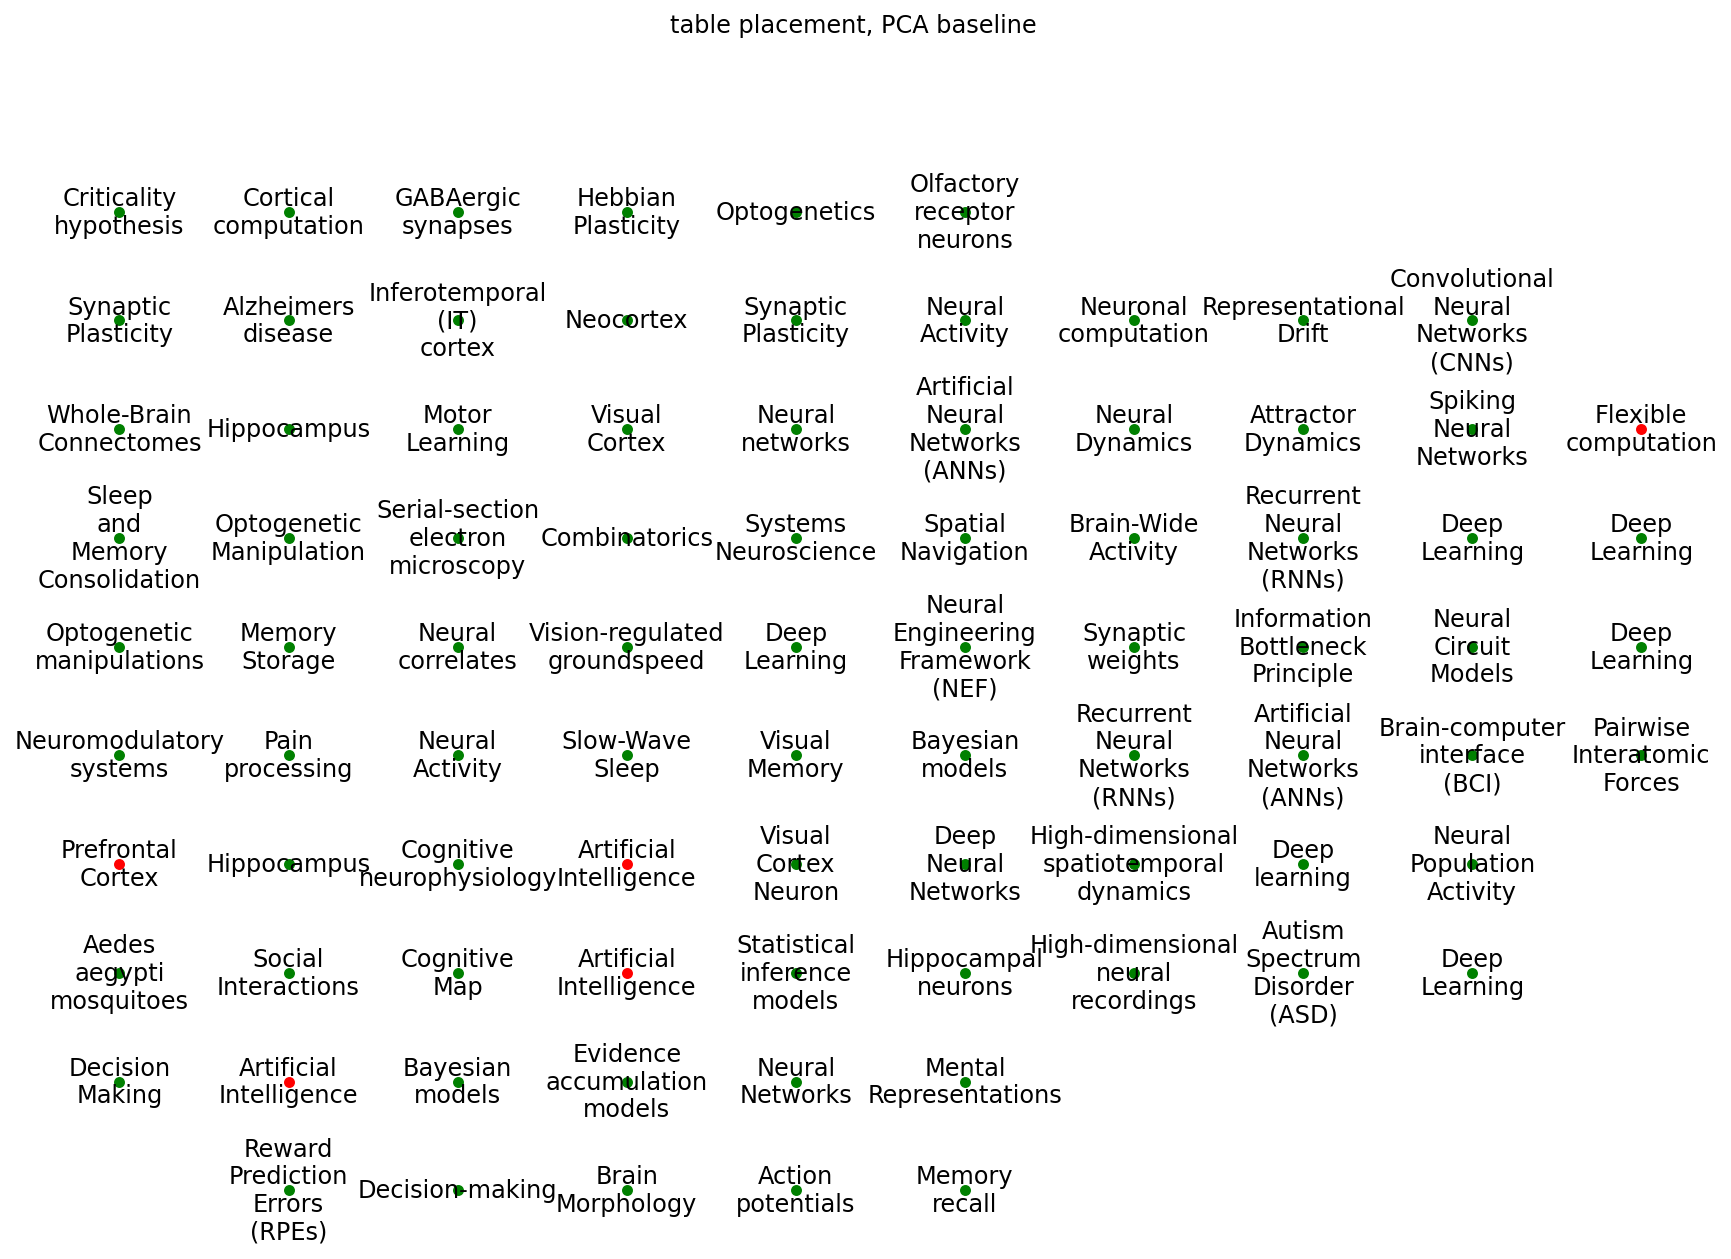

In [16]:
pca_assign, _ = find_assignments_from_coords(pcs_all, coord_map)
draw_table_assignment(df_0, pca_assign)
plt.suptitle("table placement, PCA baseline")

In [17]:
loss = calculate_loss_from_table_assignments(tsne_assign, M, connections)
loss
    

0.355751583551556

In [18]:
loss = calculate_loss_from_table_assignments(pca_assign, M, connections)
loss

0.3269080847120213

In [19]:
loss_baseline = calculate_loss_from_table_assignments(df_0.coords.values, M, connections)
loss_baseline

0.40352181740042153

In [20]:
assign = tsne_assign.copy()
for i in range(5):
    assign, loss = refine_match(assign, M, connections)
    print(loss)

tsne_assign_final = assign

0.3106314060261846
0.2871323048413226
0.2739350548267404
0.26891712146470415
0.26613681185097987


Text(0.5, 0.98, 'table placement, t-SNE improved')

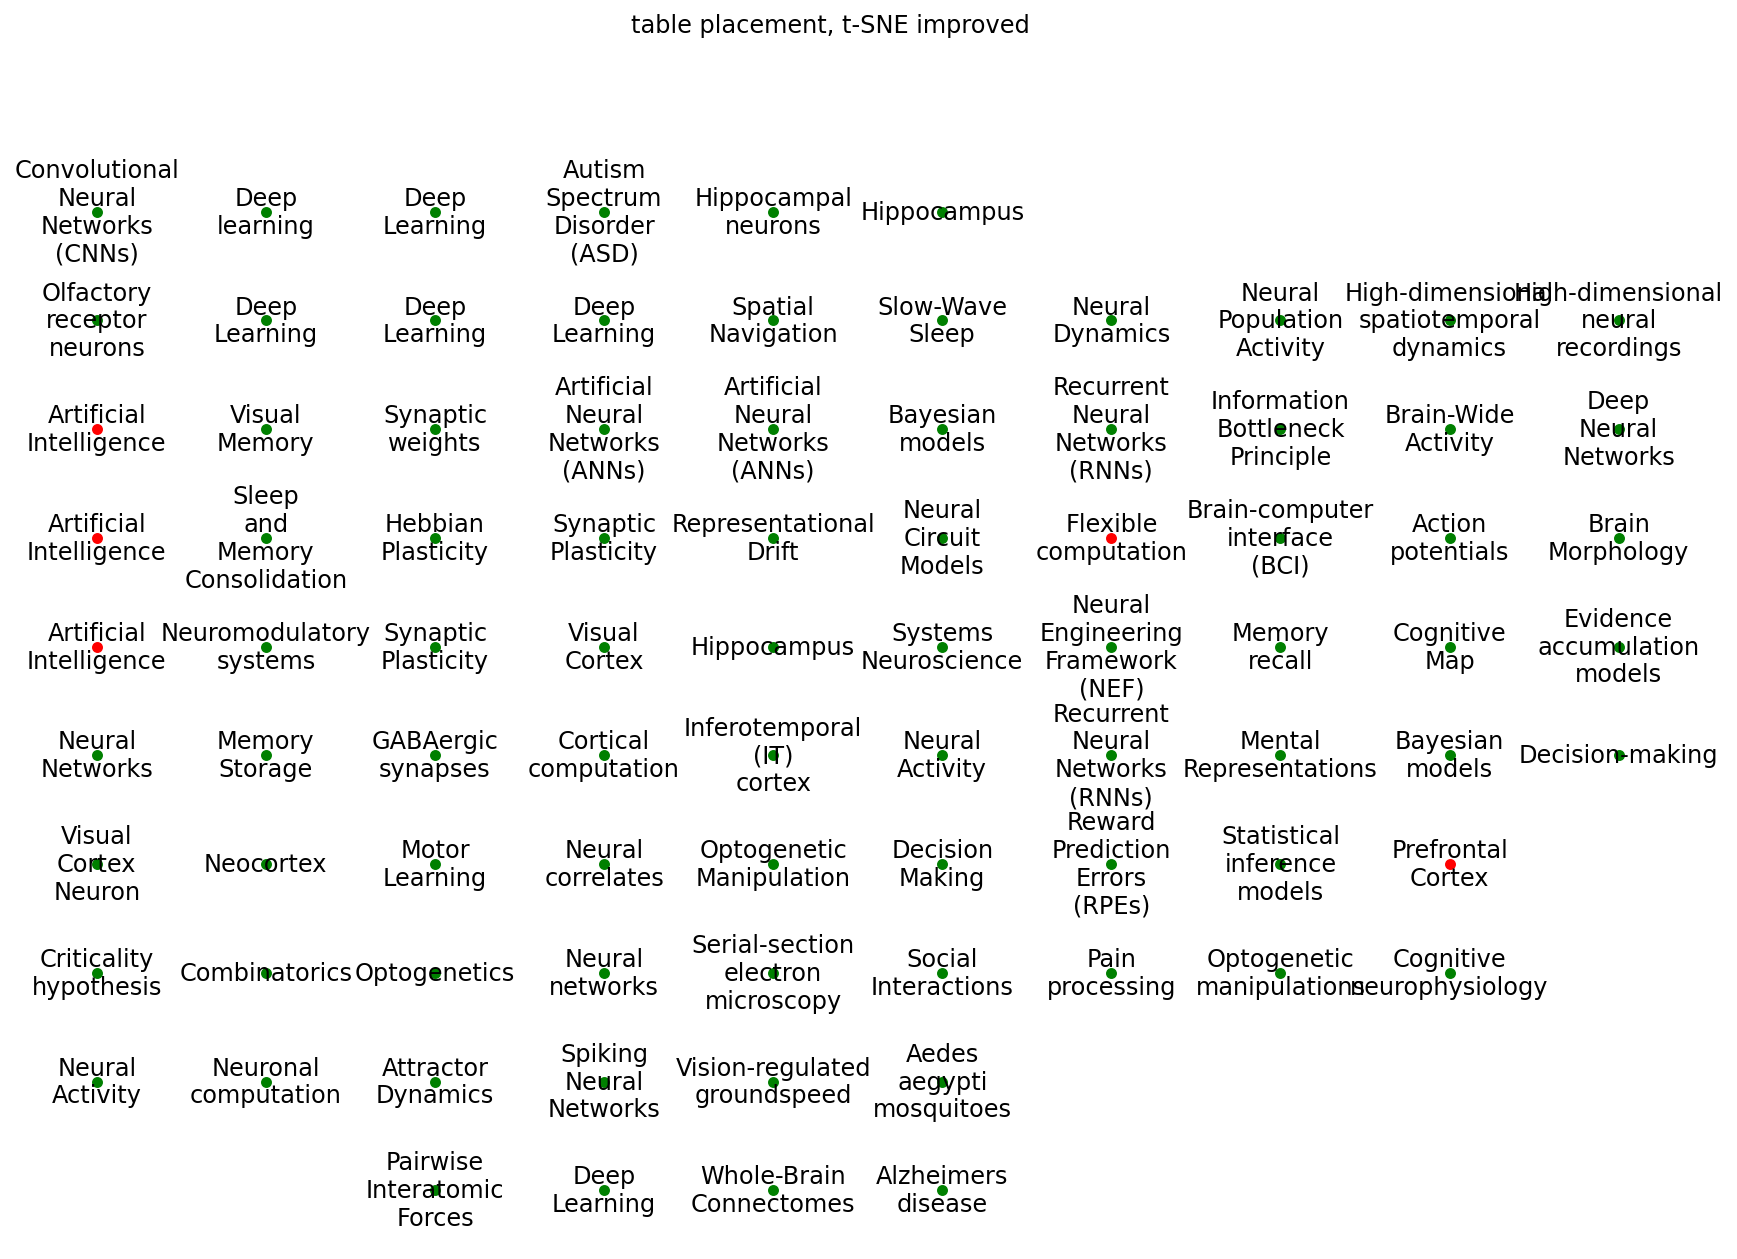

In [21]:
draw_table_assignment(df_0, tsne_assign_final)
plt.suptitle('table placement, t-SNE improved')

In [22]:
assign = pca_assign.copy()
for i in range(5):
    assign, loss = refine_match(assign, M, connections)
    print(loss)

pca_assign_final = assign

0.2747493409029588
0.25978980068780944
0.25583462834946297
0.2537283379574738
0.2529419128498486


Text(0.5, 0.98, 'table placement, PCA improved')

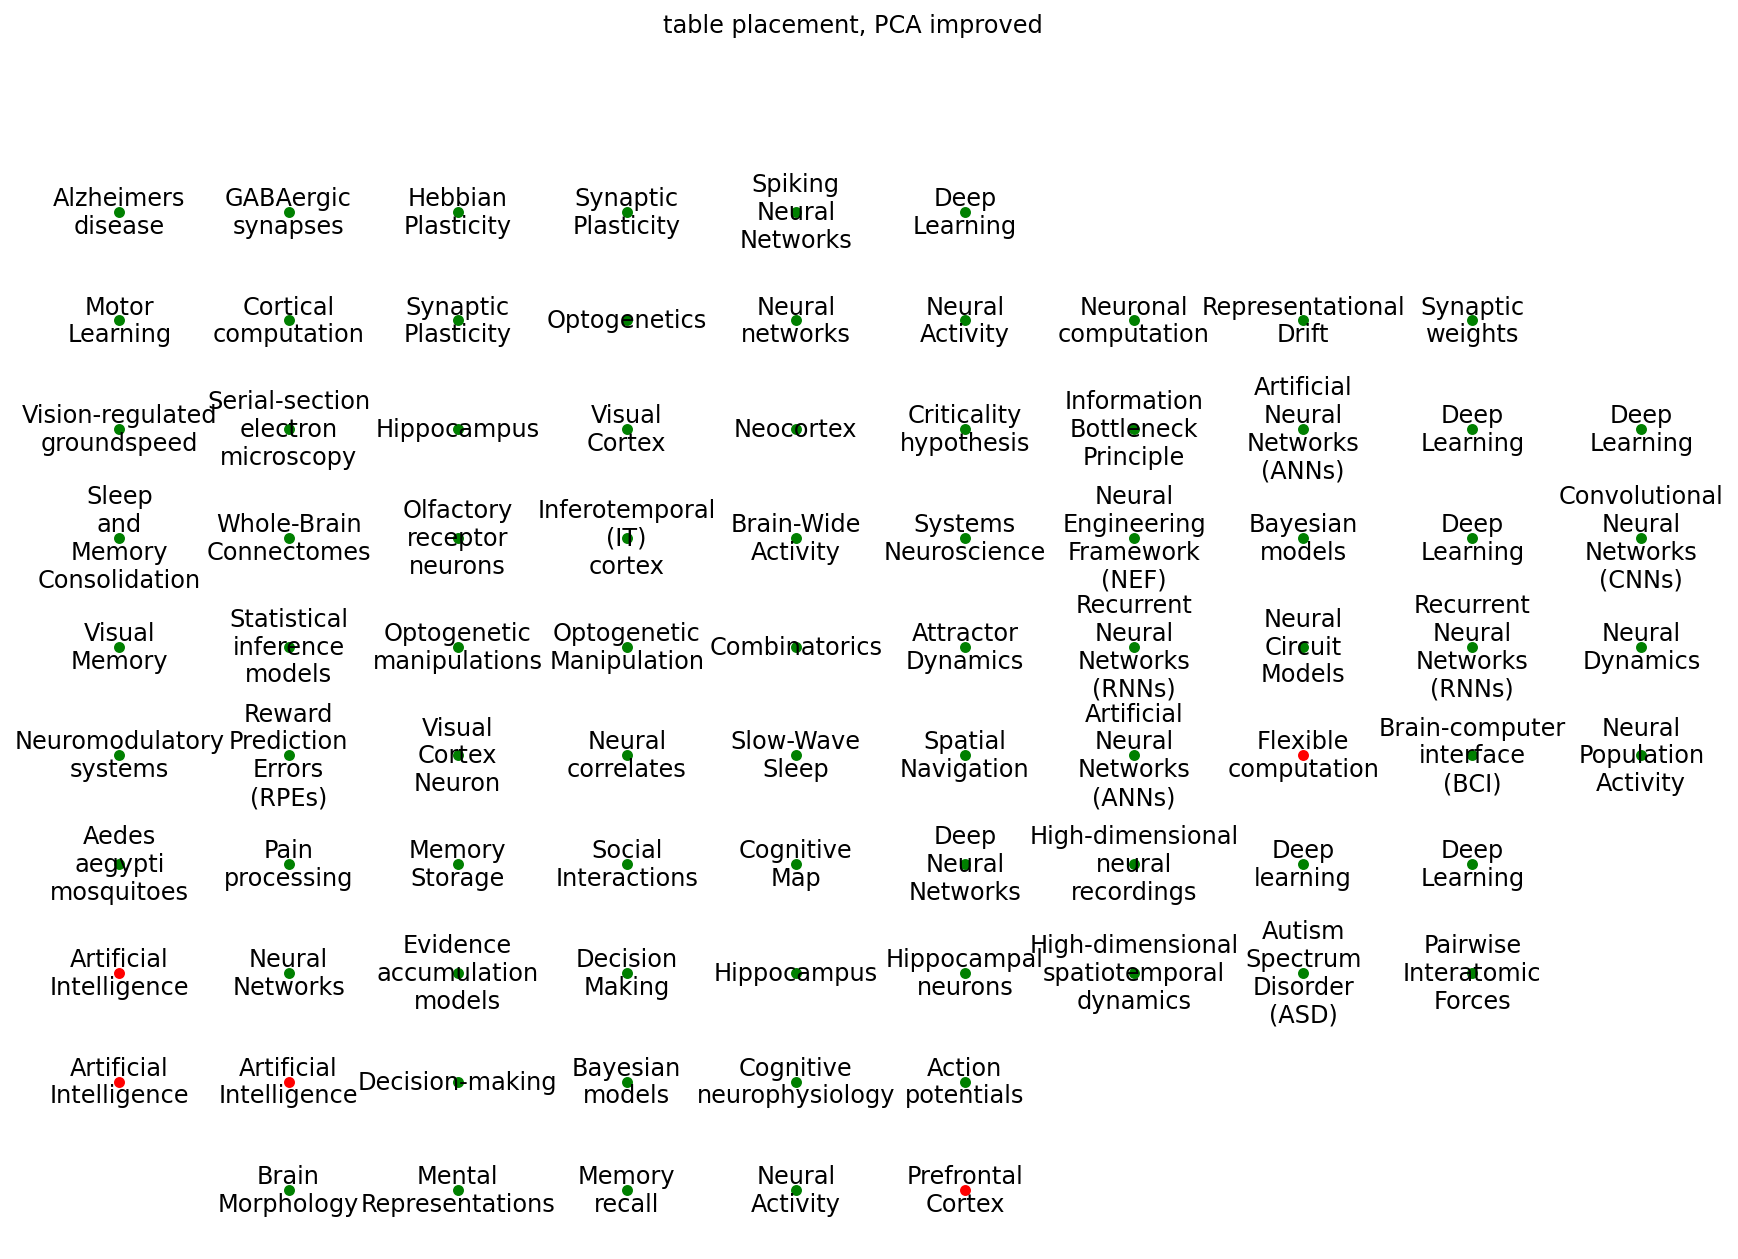

In [23]:
draw_table_assignment(df_0, pca_assign_final)
plt.suptitle('table placement, PCA improved')

In [24]:
.25 / .4

0.625